In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
train_A=pd.read_pickle('../data/task1_ArousalSim_train.pickle')
train_V=pd.read_pickle('../data/task1_ValenceSim_train.pickle')
val_A=pd.read_pickle('../data/task1_ArousalSim_val.pickle')
val_V=pd.read_pickle('../data/task1_ValenceSim_val.pickle')
train=pd.read_pickle('../data/train.pickle')
val=pd.read_pickle('../data/val.pickle')

print(f"Shapes: train={train.shape}, train_A={train_A.shape}, train_V={train_V.shape}")

# Reset indices to align by position (not by index label)
train = train.reset_index(drop=True)
train_A = train_A.reset_index(drop=True)
train_V = train_V.reset_index(drop=True)
val = val.reset_index(drop=True)
val_A = val_A.reset_index(drop=True)
val_V = val_V.reset_index(drop=True)

# Concatenate by position (all rows align)
train = pd.concat([train, train_A, train_V], axis=1)
val = pd.concat([val, val_A, val_V], axis=1)

print(f"After concat - train: {train.shape}, val: {val.shape}")
print(f"NaN check:")
print(f"  train valence NaN: {train['valence'].isna().sum()}")
print(f"  train arousal NaN: {train['arousal'].isna().sum()}")
print(f"  val valence NaN: {val['valence'].isna().sum()}")
print(f"  val arousal NaN: {val['arousal'].isna().sum()}")

train.to_pickle('../data/train+sim.pickle')
val.to_pickle('../data/val+sim.pickle')
print("\nPickle files saved successfully")
print(train.columns)

Shapes: train=(2211, 8), train_A=(2211, 5), train_V=(2211, 5)
After concat - train: (2211, 18), val: (553, 18)
NaN check:
  train valence NaN: 0
  train arousal NaN: 0
  val valence NaN: 0
  val arousal NaN: 0

Pickle files saved successfully
Index(['user_id', 'text_id', 'text', 'timestamp', 'collection_phase',
       'is_words', 'valence', 'arousal', 'Arousal.0.sim', 'Arousal.1.sim',
       'Arousal.2.sim', 'Arousal.3.sim', 'Arousal.4.sim', 'Valence.0.sim',
       'Valence.1.sim', 'Valence.2.sim', 'Valence.3.sim', 'Valence.4.sim'],
      dtype='object')


In [4]:
# Load pre-concatenated sim features (already saved in cell 2)
train_df = pd.read_pickle('../data/train+sim.pickle')
val_df = pd.read_pickle('../data/val+sim.pickle')

print(f"Loaded data - Train shape: {train_df.shape}, Val shape: {val_df.shape}")
print(f"Columns: {list(train_df.columns)}")

# Extract sim feature columns (5 Arousal + 5 Valence)
sim_cols = [col for col in train_df.columns if 'sim' in col.lower()]
print(f"\nSim columns ({len(sim_cols)}): {sim_cols}")


# Filter out samples with NaN targets (valence or arousal)
train_df = train_df.dropna(subset=['valence', 'arousal'])
val_df = val_df.dropna(subset=['valence', 'arousal'])

print(f"After filtering NaN targets - Train shape: {train_df.shape}, Val shape: {val_df.shape}")

# Extract features and targets
train_user_ids = train_df['user_id'].values
val_user_ids = val_df['user_id'].values

# Get only the sim columns that exist in each dataframe
train_sim_cols = [col for col in sim_cols if col in train_df.columns]
val_sim_cols = [col for col in sim_cols if col in val_df.columns]

X_train_sim = train_df[train_sim_cols].fillna(0).values.astype(float)
X_val_sim = val_df[val_sim_cols].fillna(0).values.astype(float)

y_train = train_df[['valence', 'arousal']].values.astype(float)
y_val = val_df[['valence', 'arousal']].values.astype(float)

print(f"\nX_train_sim: {X_train_sim.shape}, y_train: {y_train.shape}")
print(f"X_val_sim: {X_val_sim.shape}, y_val: {y_val.shape}")
print(f"\n5 Arousal sim features + 5 Valence sim features = 10 total features")


Loaded data - Train shape: (2211, 18), Val shape: (553, 18)
Columns: ['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'Arousal.0.sim', 'Arousal.1.sim', 'Arousal.2.sim', 'Arousal.3.sim', 'Arousal.4.sim', 'Valence.0.sim', 'Valence.1.sim', 'Valence.2.sim', 'Valence.3.sim', 'Valence.4.sim']

Sim columns (10): ['Arousal.0.sim', 'Arousal.1.sim', 'Arousal.2.sim', 'Arousal.3.sim', 'Arousal.4.sim', 'Valence.0.sim', 'Valence.1.sim', 'Valence.2.sim', 'Valence.3.sim', 'Valence.4.sim']
After filtering NaN targets - Train shape: (2211, 18), Val shape: (553, 18)

X_train_sim: (2211, 10), y_train: (2211, 2)
X_val_sim: (553, 10), y_val: (553, 2)

5 Arousal sim features + 5 Valence sim features = 10 total features


In [5]:
# Model: MLP with user embedding (same pattern as embedding_baseline)

class MLPModel(nn.Module):
    def __init__(self, sim_feature_dim=10, num_users=1000, user_embedding_dim=32, hidden_dim=256):
        super(MLPModel, self).__init__()
        
        # User embedding - use actual number of users
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = sim features + user embedding
        input_dim = sim_feature_dim + user_embedding_dim
        
        # Simple MLP layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 2)  # Predict valence and arousal
        
    def forward(self, x_sim, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)  # (batch_size, user_embedding_dim)
        
        # Concatenate sim features and user embedding
        combined = torch.cat([x_sim, user_embed], dim=1)  # (batch_size, input_dim)
        
        # MLP layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Setup device and prepare data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Map user IDs to 0-indexed
user_id_map = {}
train_user_id_list = []
for uid in train_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    train_user_id_list.append(user_id_map[uid])

val_user_id_list = []
for uid in val_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    val_user_id_list.append(user_id_map[uid])

num_users = len(user_id_map)
print(f"Number of unique users: {num_users}")

# Convert to tensors
X_train_sim_tensor = torch.tensor(X_train_sim, dtype=torch.float32).to(device)
X_val_sim_tensor = torch.tensor(X_val_sim, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

train_user_ids_tensor = torch.tensor(train_user_id_list, dtype=torch.long).to(device)
val_user_ids_tensor = torch.tensor(val_user_id_list, dtype=torch.long).to(device)

print(f"\nData shapes:")
print(f"  X_train_sim (10 features): {X_train_sim_tensor.shape}")
print(f"  train_user_ids (will be embedded to 32-dim): {train_user_ids_tensor.shape}")
print(f"  Combined input to MLP: ({X_train_sim_tensor.shape[0]}, {X_train_sim_tensor.shape[1] + 32}) = (2654, 42)")
print(f"  y_train: {y_train_tensor.shape}")


Using device: cuda
Number of unique users: 137

Data shapes:
  X_train_sim (10 features): torch.Size([2211, 10])
  train_user_ids (will be embedded to 32-dim): torch.Size([2211])
  Combined input to MLP: (2211, 42) = (2654, 42)
  y_train: torch.Size([2211, 2])


In [6]:
# Data diagnostics
print("=" * 60)
print("DATA DIAGNOSTICS")
print("=" * 60)
print(f"X_train_sim - NaN count: {np.isnan(X_train_sim).sum()}, Inf count: {np.isinf(X_train_sim).sum()}")
print(f"X_train_sim - Min: {np.nanmin(X_train_sim):.6f}, Max: {np.nanmax(X_train_sim):.6f}, Mean: {np.nanmean(X_train_sim):.6f}")
print(f"y_train - NaN count: {np.isnan(y_train).sum()}, Inf count: {np.isinf(y_train).sum()}")
print(f"y_train - Min: {np.nanmin(y_train):.6f}, Max: {np.nanmax(y_train):.6f}, Mean: {np.nanmean(y_train):.6f}")
print("=" * 60)


DATA DIAGNOSTICS
X_train_sim - NaN count: 0, Inf count: 0
X_train_sim - Min: 0.297747, Max: 0.901373, Mean: 0.568958
y_train - NaN count: 0, Inf count: 0
y_train - Min: -2.000000, Max: 2.000000, Mean: 0.474898


In [7]:
# Train model with early stopping
model = MLPModel(
    sim_feature_dim=X_train_sim.shape[1],
    num_users=num_users,
    user_embedding_dim=32,
    hidden_dim=512
)
model = model.to(device)

# Initialize weights with better strategy
for name, param in model.named_parameters():
    if 'weight' in name and param.dim() > 1:
        nn.init.xavier_uniform_(param, gain=0.5)
    elif 'bias' in name:
        nn.init.zeros_(param)
    elif 'user_embedding' in name:
        nn.init.normal_(param, mean=0, std=0.01)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Very conservative LR

# Training parameters
num_epochs = 100
batch_size = 32
best_val_loss = float('inf')
patience = 15
patience_counter = 0
train_losses = []
val_losses = []
best_model_state = None

print("Starting training...")
print(f"Learning rate: 0.00001, Gradient clipping: 1.0")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    num_batches = 0
    
    for i in range(0, len(X_train_sim_tensor), batch_size):
        batch_x = X_train_sim_tensor[i:i+batch_size]
        batch_user_ids = train_user_ids_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        predictions = model(batch_x, batch_user_ids)
        loss = criterion(predictions, batch_y)
        
        # Check for NaN before backward
        if torch.isnan(loss):
            print(f"WARNING: NaN loss at epoch {epoch+1}")
            break
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
    
    if num_batches > 0:
        train_loss /= num_batches
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_sim_tensor, val_user_ids_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
        val_losses.append(val_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss.item():.6f}, Patience = {patience_counter}/{patience}")
    
    # Early stopping
    if not torch.isnan(val_loss) and val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.6f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        break

print(f"Training completed! Total epochs: {epoch+1}/{num_epochs}")
print("-" * 60)


Starting training...
Learning rate: 0.00001, Gradient clipping: 1.0
------------------------------------------------------------
Epoch   1: Train Loss = 1.024018, Val Loss = 0.762079, Patience = 0/15
Epoch  10: Train Loss = 0.588764, Val Loss = 0.619915, Patience = 0/15
Epoch  20: Train Loss = 0.549731, Val Loss = 0.597507, Patience = 5/15
Epoch  30: Train Loss = 0.536864, Val Loss = 0.584359, Patience = 0/15
Epoch  40: Train Loss = 0.517538, Val Loss = 0.577944, Patience = 0/15
Epoch  50: Train Loss = 0.515722, Val Loss = 0.585897, Patience = 10/15

Early stopping at epoch 54
Best validation loss: 0.576861
Training completed! Total epochs: 54/100
------------------------------------------------------------


In [8]:
# Evaluate performance
print("=" * 60)
print("SIM BASELINE MODEL (SIM + USER_ID) PERFORMANCE")
print("=" * 60)

model.eval()
with torch.no_grad():
    train_predictions = model(X_train_sim_tensor, train_user_ids_tensor)
    val_predictions = model(X_val_sim_tensor, val_user_ids_tensor)

# Convert to numpy
train_preds_np = train_predictions.cpu().numpy()
val_preds_np = val_predictions.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
y_val_np = y_val_tensor.cpu().numpy()

# Calculate metrics
train_mse = mean_squared_error(y_train_np, train_preds_np)
train_mae = mean_absolute_error(y_train_np, train_preds_np)
val_mse = mean_squared_error(y_val_np, val_preds_np)
val_mae = mean_absolute_error(y_val_np, val_preds_np)

print(f"Train - MSE: {train_mse:.6f}, MAE: {train_mae:.6f}")
print(f"Val   - MSE: {val_mse:.6f}, MAE: {val_mae:.6f}")

# Per-dimension metrics
train_mse_valence = mean_squared_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mse_arousal = mean_squared_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mse_valence = mean_squared_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mse_arousal = mean_squared_error(y_val_np[:, 1], val_preds_np[:, 1])

train_mae_valence = mean_absolute_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mae_arousal = mean_absolute_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mae_valence = mean_absolute_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mae_arousal = mean_absolute_error(y_val_np[:, 1], val_preds_np[:, 1])

print(f"\nValence - Train MSE: {train_mse_valence:.6f}, Val MSE: {val_mse_valence:.6f}")
print(f"Arousal  - Train MSE: {train_mse_arousal:.6f}, Val MSE: {val_mse_arousal:.6f}")
print(f"\nValence - Train MAE: {train_mae_valence:.6f}, Val MAE: {val_mae_valence:.6f}")
print(f"Arousal  - Train MAE: {train_mae_arousal:.6f}, Val MAE: {val_mae_arousal:.6f}")
print("=" * 60)


SIM BASELINE MODEL (SIM + USER_ID) PERFORMANCE
Train - MSE: 0.491719, MAE: 0.537575
Val   - MSE: 0.583903, MAE: 0.592551

Valence - Train MSE: 0.605143, Val MSE: 0.705021
Arousal  - Train MSE: 0.378295, Val MSE: 0.462785

Valence - Train MAE: 0.590322, Val MAE: 0.639706
Arousal  - Train MAE: 0.484828, Val MAE: 0.545395


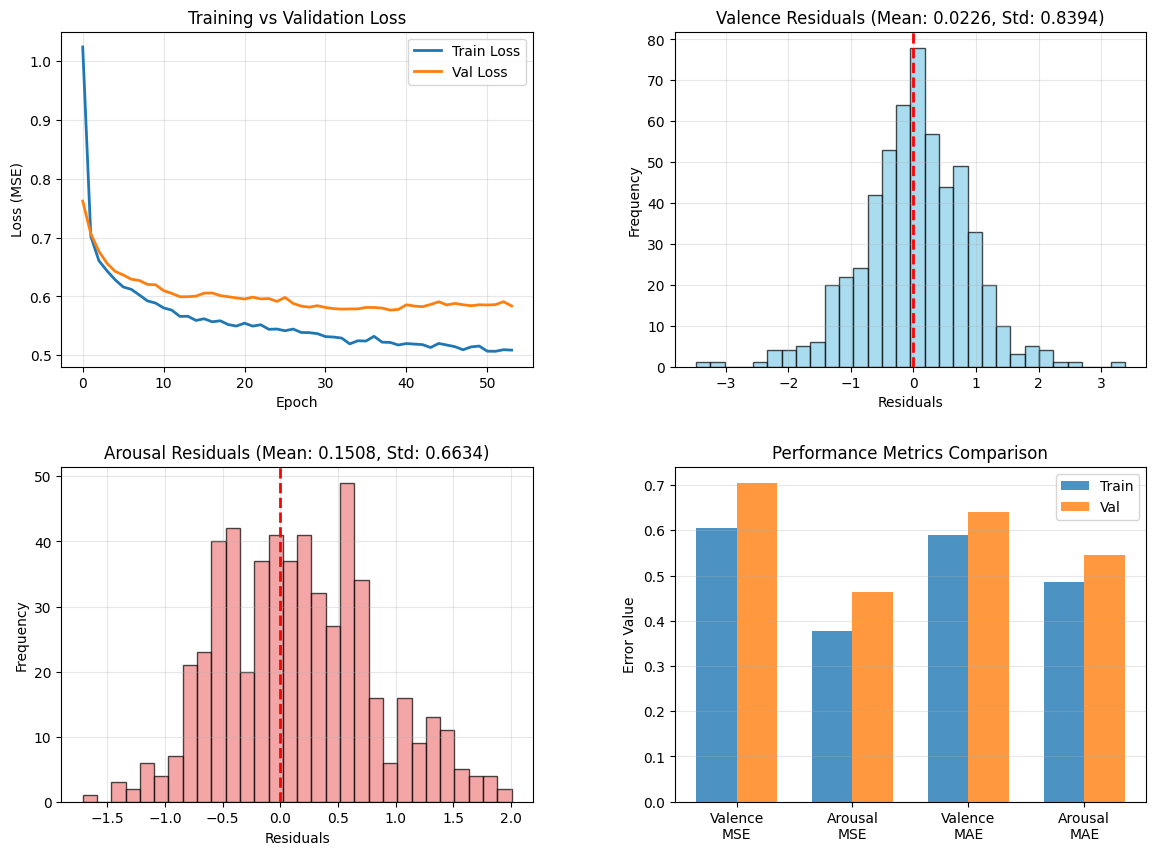

Visualization saved as 'sim_baseline_mlp_performance.png'


In [9]:
# Visualization - Sim Baseline Performance (Simplified)
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Training vs Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4. Valence residuals distribution
ax4 = fig.add_subplot(gs[0, 1])
valence_residuals = y_val_np[:, 0] - val_preds_np[:, 0]
ax4.hist(valence_residuals, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Valence Residuals (Mean: {valence_residuals.mean():.4f}, Std: {valence_residuals.std():.4f})')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.grid(True, alpha=0.3)

# 5. Arousal residuals distribution
ax5 = fig.add_subplot(gs[1, 0])
arousal_residuals = y_val_np[:, 1] - val_preds_np[:, 1]
ax5.hist(arousal_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Frequency')
ax5.set_title(f'Arousal Residuals (Mean: {arousal_residuals.mean():.4f}, Std: {arousal_residuals.std():.4f})')
ax5.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax5.grid(True, alpha=0.3)

# 9. Performance metrics comparison
ax9 = fig.add_subplot(gs[1, 1])
metrics_names = ['Valence\nMSE', 'Arousal\nMSE', 'Valence\nMAE', 'Arousal\nMAE']
train_metrics = [train_mse_valence, train_mse_arousal, train_mae_valence, train_mae_arousal]
val_metrics = [val_mse_valence, val_mse_arousal, val_mae_valence, val_mae_arousal]

x = np.arange(len(metrics_names))
width = 0.35
ax9.bar(x - width/2, train_metrics, width, label='Train', alpha=0.8)
ax9.bar(x + width/2, val_metrics, width, label='Val', alpha=0.8)
ax9.set_ylabel('Error Value')
ax9.set_title('Performance Metrics Comparison')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics_names)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.savefig('sim_baseline_mlp_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'sim_baseline_mlp_performance.png'")
